In [37]:
#Install uninstalled modules, comment if it's already installed

#%pip install -U MetaTrader5 matplotlib numpy pandas pandas_ta pickle scikit-learn

In [38]:
#Python version
!python --version

Python 3.8.12


In [39]:
#Import needed modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from finta import TA

from datetime import datetime
import os, pytz
import MetaTrader5 as mt5

import config

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib

In [40]:
#HYPER PARAMETER

In [41]:
#Trading Account Parameter
account = config.username   #Account number
password = config.password  #Password number
server = config.mt5_server  #Server name
path = config.mt5_path      #path of Metatrader5 director

mt5.initialize(
   path = path,          # path to the MetaTrader 5 terminal EXE file
   login = account,      # account number
   password = password,  # password
   server = server,      # server name as it is specified in the terminal
   #timeout = TIMEOUT,   # timeout
   portable = False      # portable mode
   )

# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__,"\n")

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize failed, error code =",mt5.last_error())
    mt5.shutdown()
else:
    print("MetaTrader5 Initialized!")
    account_info_dict = mt5.account_info()._asdict()
    acc_info = pd.DataFrame(list(account_info_dict.items()),columns=['property','value'])
    print("\n", "account_info() as dataframe:")
    print(acc_info)

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.36 

MetaTrader5 Initialized!

 account_info() as dataframe:
              property             value
0                login            647479
1           trade_mode                 0
2             leverage              1000
3         limit_orders               100
4       margin_so_mode                 0
5        trade_allowed              True
6         trade_expert              True
7          margin_mode                 2
8      currency_digits                 2
9           fifo_close             False
10             balance          99989.02
11              credit               0.0
12              profit               0.0
13              equity          99989.02
14              margin               0.0
15         margin_free          99989.02
16        margin_level               0.0
17      margin_so_call              40.0
18        margin_so_so              20.0
19      margin_initial               0.0

In [42]:
#Extract Account info from dataframe
leverage = acc_info.loc[2, "value"]
balance = acc_info.loc[10, "value"]
profit = acc_info.loc[12, "value"]
equity = acc_info.loc[13, "value"]
margin_free = acc_info.loc[15, "value"]

print(leverage)
print(balance)
print(profit)
print(equity)
print(margin_free)

1000
99989.02
0.0
99989.02
99989.02


Small Note, in terminal in `trade_allowed` variable = false in sunday

In [43]:
terminal_info_dict = mt5.terminal_info()._asdict()
terminal_info = pd.DataFrame(list(terminal_info_dict.items()),columns=['property','value'])
print("\n", "account_info() as dataframe:")
print(terminal_info)


 account_info() as dataframe:
                 property                                              value
0       community_account                                               True
1    community_connection                                               True
2               connected                                               True
3            dlls_allowed                                              False
4           trade_allowed                                              False
5       tradeapi_disabled                                              False
6           email_enabled                                              False
7             ftp_enabled                                              False
8   notifications_enabled                                              False
9                    mqid                                               True
10                  build                                               3137
11                maxbars                    

In [44]:
trade_allowed = terminal_info.loc[4, "value"]
print(trade_allowed)

False


In [45]:
# set time zone to UTC
timezone = pytz.timezone("Etc/UTC")
symbol = 'EURUSD'
timeframe = mt5.TIMEFRAME_M5
bars = 75000

def get_price(symbol, timeframe, bars):
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, bars + 1)

    # create DataFrame out of the obtained data
    rates_frame = pd.DataFrame(rates, dtype=np.dtype("float"))

    # convert time in seconds into the datetime format
    rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
    rates_frame = rates_frame.rename(columns={'tick_volume': 'volume'})
    del rates_frame['real_volume']

    rates_frame = rates_frame.set_index('time')

    return rates_frame

rates_frame = get_price(symbol, timeframe, bars)                             
# display data
print("\nDisplay dataframe with data")
rates_frame.tail()


Display dataframe with data


,open,high,low,close,volume,spread
time,,,,,,
2022-01-17 19:00:00,1.14088,1.14132,1.14079,1.14118,132.0,8.0
2022-01-17 19:05:00,1.14116,1.14150,1.14109,1.14146,105.0,8.0
2022-01-17 19:10:00,1.14145,1.14145,1.14111,1.14111,104.0,8.0
2022-01-17 19:15:00,1.14111,1.14123,1.14102,1.14114,59.0,8.0
2022-01-17 19:20:00,1.14114,1.14114,1.14096,1.14097,36.0,9.0


In [46]:
symbol_info = mt5.symbol_info(symbol)
if symbol_info!=None:
    # display the terminal data 'as is'    
    #print(symbol_info)
    print("\n","{}:".format(symbol))
    print("spread =",symbol_info.spread,", digits =",symbol_info.digits, "\n")
    print("swap long =", symbol_info.swap_long, "\n")
    print ("------------------------------")
else:
    print("There is no such symbol of {}".format(symbol))


 EURUSD:
spread = 10 , digits = 5 

swap long = -6.37 

------------------------------


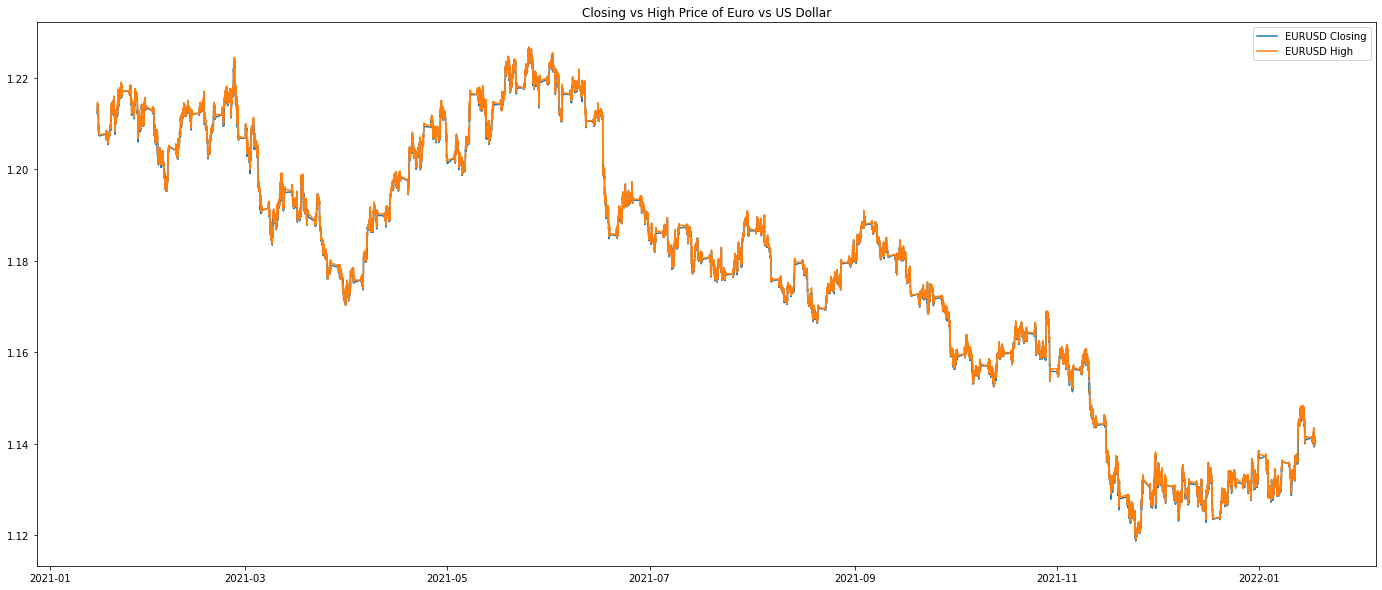

In [47]:
def plotClosing(df):
    plt.figure(figsize=(24,10))
    plt.plot(df.close, label='{} Closing'.format(symbol))
    plt.plot(df.high, label='{} High'.format(symbol))
    plt.title('Closing vs High Price of {}'.format(symbol_info.description))
    plt.legend()
    plt.show()

plotClosing(rates_frame)

In [48]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    Timeframe for calculation (5 minutes timeframe):
        6 bars for 30 minutes
        48 bars for 4 hours
        144 bars for 12 hours
        288 bars for 1 day
    """
    df_new = pd.DataFrame()
    
    # Real time features
    df_new['open'] = df['open']

    # original features
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)
    df_new['volume_1'] = df['volume'].shift(1)
    
    # indicator
    RSI = TA.RSI(df, 6).shift(1)
    AO = TA.AO(df, 34, 5).shift(1)

    df_new['EMA_30m_1'] = TA.EMA(df, 6).shift(1)
    df_new['EMA_4h_1'] = TA.EMA(df, 48).shift(1)
    df_new['RSI_1'] = RSI.shift(1)
    df_new['AO_1'] = AO.shift(1)

    # price growth
    df_new['price_growth_1-2'] = df['close'].shift(1) - df['close'].shift(2)
    df_new['price_growth_2-3'] = df['close'].shift(2) - df['close'].shift(3)
    df_new['price_growth_3-4'] = df['close'].shift(3) - df['close'].shift(4)
    df_new['price_growth_4-5'] = df['close'].shift(4) - df['close'].shift(5)

    # RSI growth
    df_new['RSI_growth_1-2'] = RSI.shift(1) - RSI.shift(2)
    df_new['RSI_growth_2-3'] = RSI.shift(2) - RSI.shift(3)
    df_new['RSI_growth_1-2'] = RSI.shift(1) - RSI.shift(2)
    df_new['RSI_growth_1-2'] = RSI.shift(1) - RSI.shift(2)

    # AO growth
    df_new['AO_growth_1-2'] = AO.shift(1) - AO.shift(2)
    df_new['AO_growth_2-3'] = AO.shift(2) - AO.shift(3)
    df_new['AO_growth_3-4'] = AO.shift(3) - AO.shift(4)
    df_new['AO_growth_3-4'] = AO.shift(4) - AO.shift(5)

    # average price ratio
    df_new['ratio_avg_price_30m_4h'] = df_new['EMA_30m_1'] / df_new['EMA_4h_1']
   
    # average volume
    df_new['avg_volume_30m'] = df['volume'].rolling(window=6).mean().shift(1)
    df_new['avg_volume_4h'] = df['volume'].rolling(window=48).mean().shift(1)
    
    # average volume ratio
    df_new['ratio_avg_volume_30m_4h'] = df_new['avg_volume_30m'] / df_new['avg_volume_4h']
    
    # standard deviation of prices
    df_new['std_price_30m'] = df['close'].rolling(window=6).std().shift(1)
    df_new['std_price_4h'] = df['close'].rolling(window=48).std().shift(1)
    
    # standard deviation ratio of prices 
    df_new['ratio_std_price_30m_4h'] = df_new['std_price_30m'] / df_new['std_price_4h']
    
    # standard deviation of volumes
    df_new['std_volume_30m'] = df['volume'].rolling(window=6).std().shift(1)
    df_new['std_volume_4h'] = df['volume'].rolling(window=48).std().shift(1)
    
    # standard deviation ratio of volumes
    df_new['ratio_std_volume_30m_4h'] = df_new['std_volume_30m'] / df_new['std_volume_4h']                                                                                  

    # the target
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new


df = generate_features(rates_frame)
df.tail()

,open,open_1,close_1,high_1,low_1,volume_1,EMA_30m_1,EMA_4h_1,RSI_1,AO_1,...,avg_volume_30m,avg_volume_4h,ratio_avg_volume_30m_4h,std_price_30m,std_price_4h,ratio_std_price_30m_4h,std_volume_30m,std_volume_4h,ratio_std_volume_30m_4h,close
time,,,,,,,,,,,,,,,,,,,,,
2022-01-17 19:00:00,1.14088,1.14064,1.14088,1.14091,1.14053,140.0,1.140606,1.140537,62.228982,0.000013,...,89.833333,161.583333,0.555957,0.000205,0.000433,0.472480,27.780689,51.284286,0.541700,1.14118
2022-01-17 19:05:00,1.14116,1.14088,1.14118,1.14132,1.14079,132.0,1.140770,1.140563,70.616729,0.000046,...,95.000000,159.041667,0.597328,0.000301,0.000451,0.666603,32.716968,49.602230,0.659587,1.14146
2022-01-17 19:10:00,1.14145,1.14116,1.14146,1.14150,1.14109,105.0,1.140967,1.140600,78.195612,0.000153,...,99.000000,157.833333,0.627244,0.000422,0.000480,0.879508,32.124757,50.206524,0.639852,1.14111
2022-01-17 19:15:00,1.14111,1.14145,1.14111,1.14145,1.14111,104.0,1.141008,1.140620,83.082735,0.000307,...,106.000000,157.979167,0.670975,0.000378,0.000492,0.768090,26.540535,50.035940,0.530429,1.14114
2022-01-17 19:20:00,1.14114,1.14111,1.14114,1.14123,1.14102,59.0,1.141046,1.140642,62.178263,0.000458,...,102.000000,155.750000,0.654896,0.000277,0.000499,0.554661,31.956220,52.015341,0.614361,1.14097


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74953 entries, 2021-01-15 13:35:00 to 2022-01-17 19:20:00
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   open                     74953 non-null  float64
 1   open_1                   74953 non-null  float64
 2   close_1                  74953 non-null  float64
 3   high_1                   74953 non-null  float64
 4   low_1                    74953 non-null  float64
 5   volume_1                 74953 non-null  float64
 6   EMA_30m_1                74953 non-null  float64
 7   EMA_4h_1                 74953 non-null  float64
 8   RSI_1                    74953 non-null  float64
 9   AO_1                     74953 non-null  float64
 10  price_growth_1-2         74953 non-null  float64
 11  price_growth_2-3         74953 non-null  float64
 12  price_growth_3-4         74953 non-null  float64
 13  price_growth_4-5         74953 non-null  

In [50]:
X = df.drop('close', axis='columns')
y = df.close

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(52467, 29)
(22486, 29)
(52467,)
(22486,)


In [51]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(X_train)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [52]:
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

'''
Score Criteria (theoratically):
    RMSE = closer to 0.0 the better
    MAE = closer to 0.0 the better, there is no negative point
    R^2 = closer to 1.0 the better, if negative it means the model is very bad
'''
def get_score(y_test, predictions_lin):
    print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
    print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
    print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

get_score(y_test, predictions_lin)

RMSE: 0.000
MAE: 0.000
R^2: 1.000


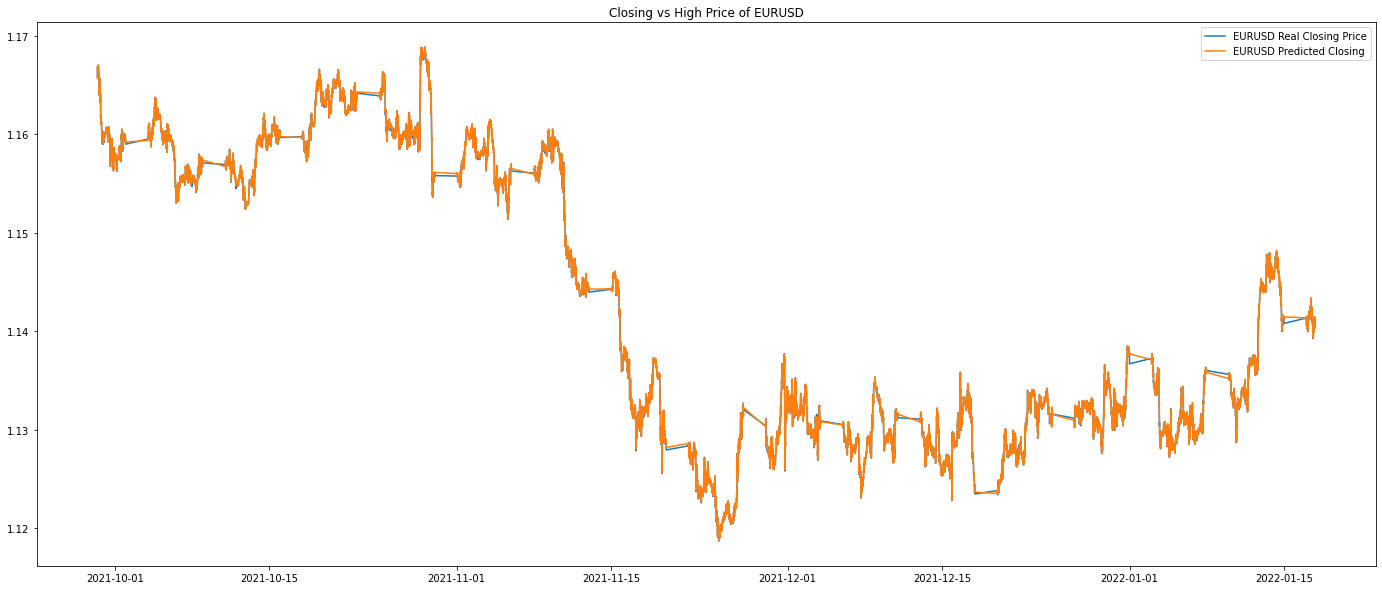

In [53]:
def plotLinearReg(y_test, predictions):
    predictions = pd.DataFrame(predictions, index=y_test.index)
    plt.figure(figsize=(24,10))
    plt.plot(y_test, label='{} Real Closing Price'.format(symbol))
    plt.plot(predictions, label='{} Predicted Closing'.format(symbol))
    plt.title('Closing vs High Price of {}'.format(symbol))
    plt.legend()
    plt.show()

plotLinearReg(y_test, predictions_lin)

In [54]:
def generate_signal(df_features, rates_frame, predictions):
    df_signal = pd.DataFrame(index=df_features.index)
    
    df_signal['predictions'] = predictions
    df_signal['predictions_5m'] = df_signal['predictions'].shift(1)
    df_signal['EMA_4h'] = TA.EMA(rates_frame, 48)
    df_signal['EMA_12h'] = TA.EMA(rates_frame, 144)

    df_signal['avg_price_30m'] = rates_frame['close'].rolling(window=6).mean().shift(1)
    df_signal['avg_price_4h'] = rates_frame['close'].rolling(window=48).mean().shift(1)

    df_signal['ratio_avg_price_30m_4h'] = df_signal['avg_price_30m'] / df_signal['avg_price_4h']

    df_signal['open'] = rates_frame['open']
    df_signal['open_5m'] = rates_frame['open'].shift(1)
    df_signal['close_5m'] = rates_frame['close'].shift(1)
    df_signal['high_5m'] = rates_frame['high'].shift(1)
    df_signal['low_5m'] = rates_frame['low'].shift(1)

    return df_signal

In [55]:
now = datetime.now() # current date and time
date_time = now.strftime("%m/%d/%Y %H:%M:%S")
print("date and time:",date_time)

date and time: 01/18/2022 00:24:10


In [56]:
model_filename = 'saved_model/Model_MetaNgepet_{}_{}.pkl'.format(symbol, timeframe)
joblib.dump(lin, open(model_filename, 'wb'))

scaler_filename = 'saved_model/Scaler_MetaNgepet_{}_{}.pkl'.format(symbol, timeframe)
joblib.dump(scaler, open(scaler_filename, 'wb'))

In [66]:
new_bars = 150

new_rates = get_price(symbol, timeframe, new_bars)
new_rates.tail()

,open,high,low,close,volume,spread
time,,,,,,
2022-01-17 19:20:00,1.14114,1.14114,1.14096,1.14101,40.0,8.0
2022-01-17 19:25:00,1.14101,1.14103,1.14085,1.14093,39.0,8.0
2022-01-17 19:30:00,1.14094,1.14107,1.14082,1.14107,45.0,8.0
2022-01-17 19:35:00,1.14107,1.14125,1.14097,1.14116,62.0,8.0
2022-01-17 19:40:00,1.14118,1.14120,1.14118,1.14120,7.0,8.0


In [67]:
new_rates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151 entries, 2022-01-17 07:10:00 to 2022-01-17 19:40:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    151 non-null    float64
 1   high    151 non-null    float64
 2   low     151 non-null    float64
 3   close   151 non-null    float64
 4   volume  151 non-null    float64
 5   spread  151 non-null    float64
dtypes: float64(6)
memory usage: 8.3 KB


In [68]:
df_signals = generate_features(new_rates)
df_signals.tail()

,open,open_1,close_1,high_1,low_1,volume_1,EMA_30m_1,EMA_4h_1,RSI_1,AO_1,...,avg_volume_30m,avg_volume_4h,ratio_avg_volume_30m_4h,std_price_30m,std_price_4h,ratio_std_price_30m_4h,std_volume_30m,std_volume_4h,ratio_std_volume_30m_4h,close
time,,,,,,,,,,,,,,,,,,,,,
2022-01-17 19:20:00,1.14114,1.14111,1.14114,1.14123,1.14102,59.0,1.141046,1.140640,62.178263,0.000458,...,102.000000,155.750000,0.654896,0.000277,0.000499,0.554661,31.956220,52.015341,0.614361,1.14101
2022-01-17 19:25:00,1.14101,1.14114,1.14101,1.14114,1.14096,40.0,1.141035,1.140655,63.132394,0.000561,...,96.666667,152.541667,0.633707,0.000194,0.000479,0.405835,39.697187,54.304876,0.731006,1.14093
2022-01-17 19:30:00,1.14094,1.14101,1.14093,1.14103,1.14085,39.0,1.141005,1.140666,55.811064,0.000609,...,79.833333,150.125000,0.531779,0.000182,0.000469,0.387961,39.055943,56.720526,0.688568,1.14107
2022-01-17 19:35:00,1.14107,1.14094,1.14107,1.14107,1.14082,45.0,1.141024,1.140683,51.408548,0.000579,...,65.333333,146.979167,0.444507,0.000183,0.000454,0.402058,31.168360,58.287800,0.534732,1.14116
2022-01-17 19:40:00,1.14118,1.14107,1.14116,1.14125,1.14097,62.0,1.141063,1.140702,58.313973,0.000511,...,58.166667,145.083333,0.400919,0.000087,0.000439,0.198048,24.441086,59.553957,0.410402,1.14120


In [69]:
df_signals.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103 entries, 2022-01-17 11:10:00 to 2022-01-17 19:40:00
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   open                     103 non-null    float64
 1   open_1                   103 non-null    float64
 2   close_1                  103 non-null    float64
 3   high_1                   103 non-null    float64
 4   low_1                    103 non-null    float64
 5   volume_1                 103 non-null    float64
 6   EMA_30m_1                103 non-null    float64
 7   EMA_4h_1                 103 non-null    float64
 8   RSI_1                    103 non-null    float64
 9   AO_1                     103 non-null    float64
 10  price_growth_1-2         103 non-null    float64
 11  price_growth_2-3         103 non-null    float64
 12  price_growth_3-4         103 non-null    float64
 13  price_growth_4-5         103 non-null    fl

In [70]:
new_X = df_signals.drop('close', axis='columns')
new_y = df_signals.close

signal_scaled = scaler.transform(new_X)

In [71]:
# load the model from disk
loaded_model = joblib.load(open(model_filename, 'rb'))

new_predictions = loaded_model.predict(signal_scaled)

get_score(new_y, new_predictions)

RMSE: 0.000
MAE: 0.000
R^2: 0.897


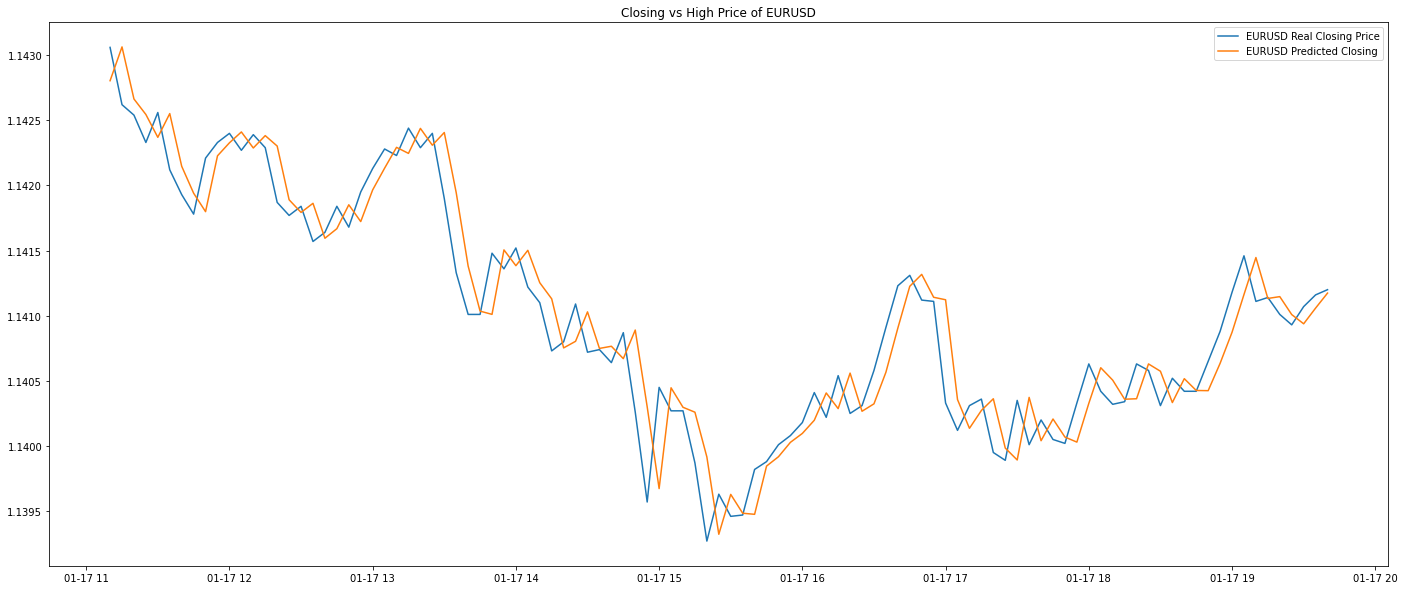

In [72]:
plotLinearReg(new_y, new_predictions)

In [73]:
df_model = generate_signal(df_signals, new_rates, new_predictions)
df_model.tail()

,predictions,predictions_5m,EMA_4h,EMA_12h,avg_price_30m,avg_price_4h,ratio_avg_price_30m_4h,open,open_5m,close_5m,high_5m,low_5m
time,,,,,,,,,,,,
2022-01-17 19:20:00,1.141147,1.141133,1.140655,1.140988,1.141070,1.140390,1.000596,1.14114,1.14111,1.14114,1.14123,1.14102
2022-01-17 19:25:00,1.141009,1.141147,1.140666,1.140987,1.141130,1.140426,1.000617,1.14101,1.14114,1.14101,1.14114,1.14096
2022-01-17 19:30:00,1.140938,1.141009,1.140683,1.140989,1.141138,1.140453,1.000601,1.14094,1.14101,1.14093,1.14103,1.14085
2022-01-17 19:35:00,1.141059,1.140938,1.140702,1.140991,1.141120,1.140487,1.000555,1.14107,1.14094,1.14107,1.14107,1.14082
2022-01-17 19:40:00,1.141174,1.141059,1.140723,1.140995,1.141070,1.140522,1.000480,1.14118,1.14107,1.14116,1.14125,1.14097


In [74]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103 entries, 2022-01-17 11:10:00 to 2022-01-17 19:40:00
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   predictions             103 non-null    float64
 1   predictions_5m          102 non-null    float64
 2   EMA_4h                  103 non-null    float64
 3   EMA_12h                 103 non-null    float64
 4   avg_price_30m           103 non-null    float64
 5   avg_price_4h            103 non-null    float64
 6   ratio_avg_price_30m_4h  103 non-null    float64
 7   open                    103 non-null    float64
 8   open_5m                 103 non-null    float64
 9   close_5m                103 non-null    float64
 10  high_5m                 103 non-null    float64
 11  low_5m                  103 non-null    float64
dtypes: float64(12)
memory usage: 10.5 KB
